# Train and Tune the Models

In [1]:
import os

import optuna

from src.config import Config
from src.data import time_series_split
from src.models.classical import LinearElasticNet
from src.preprocessing import get_preprocessor
from src.train import ModelTrainer
from src.utils import load_csv, set_seed

from pathlib import Path

In [2]:
os.environ["WANDB_MODE"] = "offline"

In [3]:
cfg = Config("../config/config.yaml")
rng = set_seed(cfg.runtime.seed)

2025-08-17 17:37:41,561 - INFO - src.utils - Global random seed set to 42


In [4]:
df_full = load_csv(str(os.path.join(cfg.data.processed_dir, cfg.data.name_features_full)))
df_ml = df_full.drop(columns=["open", "high", "low", "close", "volume", "adj_close"]).copy()
df_ml

,date,pos,neu,neg,pos_minus_neg,emb_0,emb_1,emb_2,emb_3,emb_4,...,sma_10,ema_10,lag_25,sma_25,ema_25,quarter,dow,q_mean,q_std,q_skew
0,2008-09-16,0.649857,0.037859,0.312283,0.337574,-0.379048,-0.198304,-0.910614,0.791118,0.318494,...,-0.004057,-0.003995,0.004085,-0.002534,-0.002034,3,1,0.000048,0.012294,-0.837789
1,2008-09-17,0.695084,0.020132,0.284784,0.410300,-0.580982,-0.311309,-0.798957,0.784174,0.422490,...,-0.008344,-0.010810,-0.011943,-0.003716,-0.005068,3,2,0.000048,0.012294,-0.837789
2,2008-09-18,0.751735,0.076621,0.171643,0.580092,-0.516051,-0.407941,-0.825400,0.645514,0.481609,...,-0.001518,-0.001951,-0.009451,-0.001821,-0.001761,3,3,0.000048,0.012294,-0.837789
3,2008-09-19,0.772076,0.000513,0.227411,0.544664,-0.425247,-0.328038,-0.681346,0.687526,0.308910,...,0.001482,0.004389,0.007168,-0.000791,0.000906,3,4,0.000048,0.012294,-0.837789
4,2008-09-22,0.619301,0.100864,0.279835,0.339466,-0.391367,-0.223390,-0.905261,0.678576,0.288859,...,-0.004396,-0.002460,0.003778,-0.002273,-0.001724,3,0,0.000048,0.012294,-0.837789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,2016-06-27,0.684537,0.065429,0.250034,0.434503,-0.126545,-0.069503,-0.505809,0.675737,0.537852,...,-0.003397,-0.006286,0.003752,-0.000833,-0.002734,2,0,0.000062,0.009649,-0.181613
1959,2016-06-28,0.714076,0.086932,0.198991,0.515085,-0.035628,0.026517,-0.447723,0.623409,0.638349,...,-0.001511,-0.002307,-0.000458,-0.000191,-0.001324,2,1,0.000062,0.009649,-0.181613
1960,2016-06-29,0.673349,0.114712,0.211939,0.461410,-0.183834,-0.045571,-0.742004,0.678196,0.518598,...,0.000309,0.001064,0.012110,-0.000026,0.000027,2,2,0.000062,0.009649,-0.181613
1961,2016-06-30,0.727080,0.040575,0.232345,0.494736,-0.142834,-0.103121,-0.675863,0.680667,0.464056,...,0.001104,0.003273,0.008182,0.000175,0.001041,2,3,0.000062,0.009649,-0.181613


In [5]:
train, val, test, forecast = time_series_split(df_ml, train_ratio=0.8, val_ratio=0.1, horizon=30)

In [6]:
X_train, y_train = train.drop(columns=["date", "target"]), train["target"]
X_val, y_val = val.drop(columns=["date", "target"]), val["target"]
X_test, y_test = test.drop(columns=["date", "target"]), test["target"]
X_forecast = forecast.drop(columns=["date", "target"])

In [7]:
model = LinearElasticNet(horizon=30)
preprocessor, _ = get_preprocessor(X_train)

config = {
    "model": "linear_elasticnet",
    "optimization_metric": "rmse"
}

trainer = ModelTrainer(
    model=model,
    name="linear_elasticnet",
    config=config,
    preprocessor=preprocessor,
    output_path=cfg.data.models_dir
)

2025-08-17 17:37:41,847 - INFO - ModelTrainer - Initialized ModelTrainer for model: linear_elasticnet


In [8]:
from optuna.integration.wandb import WeightsAndBiasesCallback

opt_metric = config.get("optimization_metric", "rmse")

wandb_callback = WeightsAndBiasesCallback(
    metric_name=opt_metric,
    wandb_kwargs={
        "project": "stock_forecasting",
        "name": "optuna_tuning_run",
        "tags": ["optuna", "linear_elasticnet"],
        "dir": Path("../data/models").resolve()
    }
)

C:\Users\Vito\AppData\Local\Temp\ipykernel_1920\3329073828.py:5: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandb_callback = WeightsAndBiasesCallback(


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: trainer.objective(trial, X_train, y_train, n_splits=5),
    n_trials=30,
    callbacks=[wandb_callback]
)

best_params = study.best_params
print("Best params:", best_params)

[I 2025-08-17 17:37:43,774] A new study created in memory with name: no-name-7f556138-b9b1-47ba-af37-e75391729e55
2025-08-17 17:37:43,794 - INFO - ModelTrainer - Running Optuna trial with params: {'alpha': 0.5409265632025744, 'l1_ratio': 0.7386036441619197}
2025-08-17 17:37:43,842 - INFO - LinearElasticNet - Starting model training...
2025-08-17 17:37:43,921 - INFO - LinearElasticNet - Starting model training...
2025-08-17 17:37:43,931 - INFO - LinearElasticNet - Starting model training...
2025-08-17 17:37:43,941 - INFO - LinearElasticNet - Starting model training...
2025-08-17 17:37:43,955 - INFO - LinearElasticNet - Starting model training...
[I 2025-08-17 17:37:43,957] Trial 0 finished with value: 0.00884624960386469 and parameters: {'alpha': 0.5409265632025744, 'l1_ratio': 0.7386036441619197}. Best is trial 0 with value: 0.00884624960386469.
2025-08-17 17:37:43,958 - INFO - ModelTrainer - Running Optuna trial with params: {'alpha': 0.2674380549248838, 'l1_ratio': 0.2815402397864227

Best params: {'alpha': 0.5409265632025744, 'l1_ratio': 0.7386036441619197}


In [10]:
best_model = LinearElasticNet(horizon=30, **best_params)
trainer = ModelTrainer(best_model, name="lin_reg_best", config=best_params, preprocessor=preprocessor)
trainer.fit(X_train, y_train)

2025-08-17 17:37:45,434 - INFO - ModelTrainer - Initialized ModelTrainer for model: lin_reg_best
2025-08-17 17:37:45,434 - INFO - ModelTrainer - Starting model training...
2025-08-17 17:37:45,441 - INFO - LinearElasticNet - Starting model training...


In [11]:
eval_metrics = trainer.evaluate(X_test, y_test)
print(eval_metrics)

2025-08-17 17:37:45,456 - INFO - ModelTrainer - Evaluating model...


{'mae': 0.007289961857065401, 'mse': 9.201939141539391e-05, 'rmse': 0.009592673840770045, 'smape': 1.7216313113091284, 'r2': -1.8458624130079926e-05}


In [12]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_contour(study)
vis.plot_parallel_coordinate(study)

In [13]:
model_path = trainer.save()
trainer.track_wandb(metrics=eval_metrics, model_path=model_path)

alpha,▁▁▁▂▁▁▁▁▁▁█▁▆▁▂▁▁▁▂▁▂▁▁▁▁▂▄▁▁▂
l1_ratio,▆▃▅▄█▃▅▇▅▂▆▂▃▆▁█▇▆▄▂▄▅▅▇▆▅▃▄▆▃
rmse,▁▁▁▁▁▃▂▃▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
alpha,0.86949
l1_ratio,0.25613
rmse,0.00885


mae,▁
mse,▁
r2,▁
rmse,▁
smape,▁
mae,0.00729
mse,9e-05
r2,-2e-05
rmse,0.00959
smape,1.72163


In [14]:
import numpy as np


print("Target variance:", np.var(y_test))

Target variance: 9.201769289538744e-05


In [15]:
import pandas as pd
from matplotlib import pyplot as plt


def plot_forecast_from_predictions(
        full_df: pd.DataFrame,
        forecast_df: pd.DataFrame,
        predicted_returns: np.ndarray,
        price_col: str = "adj_close",
        forecast_col: str = "Forecasted Price",
        title: str = "Forecasted Prices vs Actual",
        zoom_days: int = 180,
        figsize=(14, 6)
):
    """
    Plot actual vs forecasted prices using predicted log returns from the model.

    Parameters:
    - full_df: The complete original DataFrame with prices.
    - forecast_df: The subset used for forecasting (e.g., last horizon days).
    - predicted_returns: Model's predicted log returns.
    - price_col: Column name with actual prices.
    - forecast_col: Name of column to store forecasted prices.
    - title: Plot title.
    - zoom_days: Days to show in the zoomed-in plot.
    - figsize: Size of the plot.
    """
    df = full_df.copy()
    forecast_idx = forecast_df.index

    # Get last known price
    last_price = df.loc[forecast_idx[0] - 1, price_col]

    # Convert log returns to prices
    predicted_prices = [last_price]
    for ret in predicted_returns:
        predicted_prices.append(predicted_prices[-1] * np.exp(ret))
    predicted_prices = predicted_prices[1:]

    # Add forecast to DataFrame
    df.loc[forecast_idx, forecast_col] = predicted_prices

    # Zoomed view
    zoom_start = max(df.index[-1] - zoom_days, 0)
    df_zoom = df.iloc[zoom_start:]

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(df_zoom[price_col], label="Actual Price", linewidth=2)
    plt.plot(df_zoom[forecast_col], label="Forecasted Price", linestyle="--", color="orange")
    plt.axvline(x=forecast_idx[0], color="gray", linestyle="--", label="Forecast Start")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


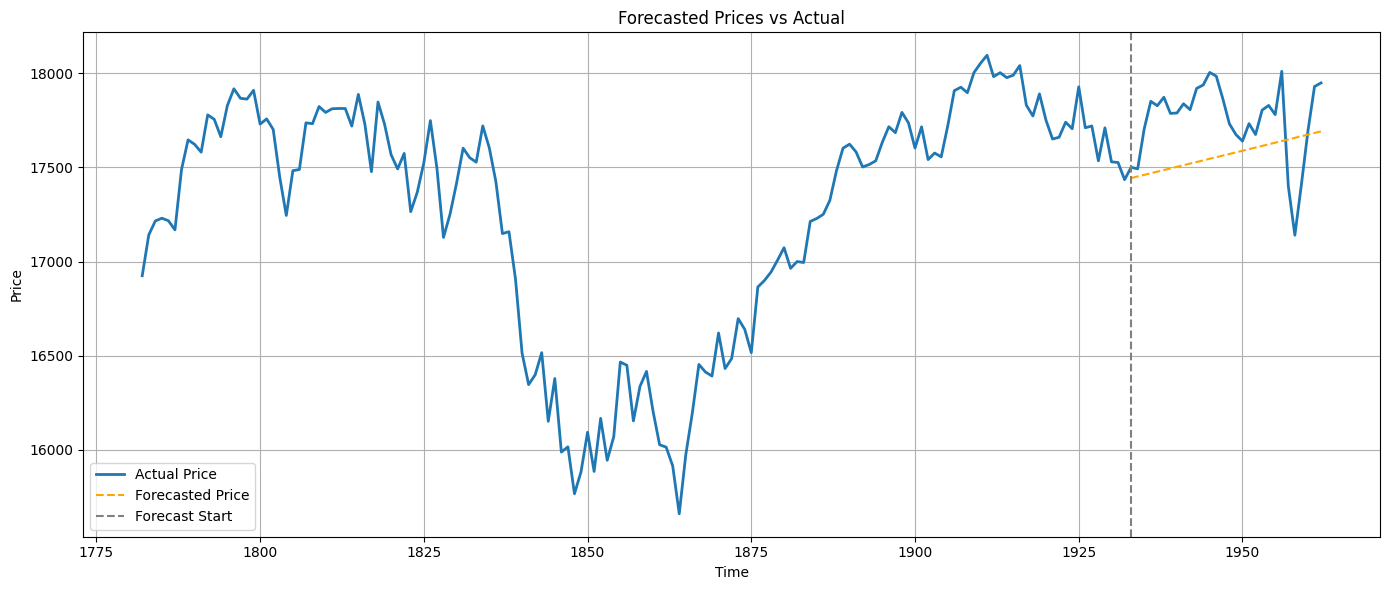

In [16]:
# Predict future returns
y_forecast_pred = trainer.predict(X_forecast)

# Plot
plot_forecast_from_predictions(
    full_df=df_full,              # full dataset with 'adj_close'
    forecast_df=forecast,        # forecast split
    predicted_returns=y_forecast_pred.ravel(),  # flatten if 2D
    price_col="adj_close",
    forecast_col="forecasted_price"
)